In [1]:
import pandas as pd
import numpy as np

In [2]:
raw_df = pd.read_csv('credit_data.csv')

In [3]:
# drop unneeded columns
raw_df.drop(columns=['Unnamed: 0'], inplace=True)

# current col names are X1, X2...add better col names
columns = ['Limit','Sex','Education','Marriage','Age','Hist_6',\
           'Hist_5','Hist_4','Hist_3','Hist_2','Hist_1','Bill_6',\
           'Bill_5','Bill_4','Bill_3','Bill_2','Bill_1','Pay_6',\
           'Pay_5','Pay_4','Pay_3','Pay_2','Pay_1','Default']
raw_df.columns = columns

# drop header from first row
raw_df = raw_df.drop([0]).reset_index()

# re-order the columns
columns=['Default','Limit','Sex','Education','Marriage','Age',\
         'Bill_1','Bill_2','Bill_3','Bill_4','Bill_5','Bill_6',\
         'Pay_1','Pay_2','Pay_3','Pay_4','Pay_5','Pay_6',\
         'Hist_1','Hist_2','Hist_3','Hist_4','Hist_5','Hist_6']
raw_df = raw_df[columns]

# replace encoded features with categorical values
raw_df = raw_df.astype(int)
raw_df['Sex'].replace([1,2],['Male','Female'], inplace=True)
raw_df['Education'].replace([0,1,2,3,4,5,6],['Others','Graduate','University','High_School','Others','Others','Others'], inplace=True)
raw_df['Marriage'].replace([0,1,2,3],['Others','Married','Single','Others'], inplace=True)

In [4]:
raw_df

,Default,Limit,Sex,Education,Marriage,Age,Bill_1,Bill_2,Bill_3,Bill_4,...,Pay_3,Pay_4,Pay_5,Pay_6,Hist_1,Hist_2,Hist_3,Hist_4,Hist_5,Hist_6
0,1,20000,Female,University,Married,24,0,0,0,689,...,0,0,689,0,-2,-2,-1,-1,2,2
1,1,120000,Female,University,Single,26,3261,3455,3272,2682,...,1000,1000,1000,0,2,0,0,0,2,-1
2,0,90000,Female,University,Single,34,15549,14948,14331,13559,...,1000,1000,1500,1518,0,0,0,0,0,0
3,0,50000,Female,University,Married,37,29547,28959,28314,49291,...,1100,1200,2019,2000,0,0,0,0,0,0
4,0,50000,Male,University,Married,57,19131,19146,20940,35835,...,9000,10000,36681,2000,0,0,0,-1,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0,220000,Male,High_School,Married,39,15980,31237,88004,208365,...,3047,5003,20000,8500,0,0,0,0,0,0
29996,0,150000,Male,High_School,Single,43,0,5190,8979,3502,...,129,8998,3526,1837,0,0,-1,-1,-1,-1
29997,1,30000,Male,University,Single,37,19357,20582,20878,2758,...,4200,22000,0,0,0,0,-1,2,3,4
29998,1,80000,Male,High_School,Married,41,48944,11855,52774,76304,...,1926,1178,3409,85900,-1,0,0,0,-1,1


## Split Train, test, val

In [7]:
# Separate train, val, and test data

from sklearn.model_selection import train_test_split

# Separate features from label
X = raw_df.drop(columns='Default')
y = raw_df['Default']

# Hold out 20% test data
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4444)

# Hold out 25% of remainder for validation
X_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=4444)

## Create dummies

In [8]:
# One hot encode categoricals for Train, (Val- skip), and Test sets

from sklearn.preprocessing import OneHotEncoder

# Define the categoricals
categoricals = ['Sex','Education','Marriage']

#
# Train data
#
# Initialize
ohe = OneHotEncoder(sparse=False)
# Create a matrix of encoded variables
cat_matrix_train = ohe.fit_transform(X_train.loc[:, categoricals])
# Turn the matrix into a dataframe
X_train_ohe = pd.DataFrame(cat_matrix_train,
                           columns=ohe.get_feature_names(categoricals), # use real column names
                           index=X_train.index) # get index position form training data
# Combine encoded categoricals with the numeric training data
X_train_preprocessed = pd.concat([X_train.drop(columns=categoricals), X_train_ohe], axis=1)

#
# Val data - don't need when doing kfold cross val
#
ohe = OneHotEncoder(sparse=False)
cat_matrix_val = ohe.fit_transform(x_val.loc[:, categoricals])
x_val_ohe = pd.DataFrame(cat_matrix_val,
                           columns=ohe.get_feature_names(categoricals),
                           index=x_val.index)
x_val_preprocessed = pd.concat([x_val.drop(columns=categoricals), x_val_ohe], axis=1)

#
# Test data
#
ohe = OneHotEncoder(sparse=False)
cat_matrix_test = ohe.fit_transform(x_test.loc[:, categoricals])
x_test_ohe = pd.DataFrame(cat_matrix_test,
                           columns=ohe.get_feature_names(categoricals),
                           index=x_test.index)
x_test_preprocessed = pd.concat([x_test.drop(columns=categoricals), x_test_ohe], axis=1)

## Scale

In [ ]:
# Scale data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train_preprocessed)
X_train_preprocessed_scaled = scaler.transform(X_train_preprocessed)
x_val_preprocessed_scaled = scaler.transform(x_val_preprocessed)
x_test_preprocessed_scaled = scaler.transform(x_test_preprocessed)

## Balance classes

percent default cases = 	22.12%
number non-default cases = 	23364
number default cases = 		6636


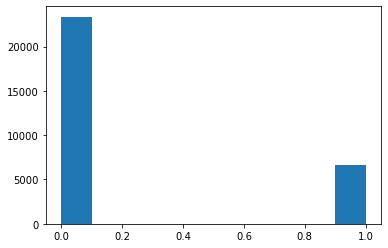

In [54]:
import matplotlib.pyplot as plt
plt.hist(raw_df['Default']);
print('percent default cases = \t{}%'.format(100*(raw_df['Default'] == 1).sum() / len(raw_df)))
print('number non-default cases = \t{}'.format((raw_df['Default'] == 0).sum()))
print('number default cases = \t\t{}'.format((raw_df['Default'] == 1).sum()))

In [64]:
def_ind = y_train.index[y_train==1]
nodef_ind = y_train.index[y_train==0]

In [84]:
X_tr_def = X_train_preprocessed.loc[def_ind]
X_tr_nodef = X_train_preprocessed.loc[nodef_ind]

In [ ]:
X_tr_scaled_def = X_train_preprocessed_scaled.loc[def_ind]
X_tr_scaled_nodef = X_train_preprocessed_scaled.loc[nodef_ind]

In [101]:
import random
ind_upsampled = random.choices(X_tr_def.index, k=len(X_tr_nodef))
len(ind_upsampled)

## KNN (k: 1-20)

In [16]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

k_val = []
k_acc = []

for k in range(1,21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_preprocessed_scaled, y_train)
    acc = knn.score(x_val_preprocessed_scaled, y_val)
    k_acc.append(acc)
    k_val.append(k)

In [17]:
# Put those lists into a df:
knn_raw_scores_val = pd.DataFrame(list(zip(k_val, k_acc)),\
                              columns=['k','acc'])

import pickle
# Pickle the knn scores
with open('knn_raw_scores_val.pickle', 'wb') as to_write:
    pickle.dump(knn_raw_scores_val, to_write)



In [18]:
# Read
import pickle
with open('knn_raw_scores_val.pickle','rb') as read_file:
    knn_raw_scores_val = pickle.load(read_file)

max accuracy is 0.806 at k = 19


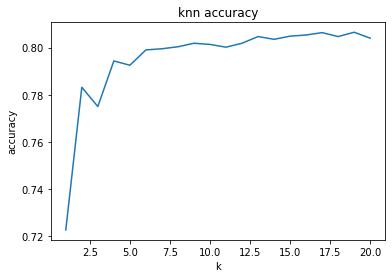

In [19]:
import matplotlib.pyplot as plt

plt.plot(knn_raw_scores_val['k'],\
             knn_raw_scores_val['acc'])
plt.title('knn accuracy')
plt.ylabel('accuracy')
plt.xlabel('k');


score = max(knn_raw_scores_val['acc'])
idx = np.argmax(knn_raw_scores_val['acc'])
print('max accuracy is {:.3f} at k = {}'\
      .format(score, knn_raw_scores_val['k'].iloc[idx]))

## Scale training data and assess 6 different models

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train_preprocessed)
X_train_preprocessed_scaled = scaler.transform(X_train_preprocessed)

In [22]:

model_list = []
scores_list = []

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=19)
knn.fit(X_train_preprocessed_scaled, y_train)
knn_score = knn.score(x_val_preprocessed_scaled,y_val)
model_list.append('KNN')
scores_list.append(knn_score)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_preprocessed, y_train)
lr_score = lr.score(x_val_preprocessed,y_val)
model_list.append('LR')
scores_list.append(lr_score)

from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train_preprocessed, y_train)
nb_score = nb.score(x_val_preprocessed,y_val)
model_list.append('NB')
scores_list.append(nb_score)

from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train_preprocessed, y_train)
svc_score = svc.score(x_val_preprocessed,y_val)
model_list.append('SVC')
scores_list.append(svc_score)
                           
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train_preprocessed, y_train)
dt_score = dt.score(x_val_preprocessed,y_val)
model_list.append('DT')
scores_list.append(dt_score)
                           
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train_preprocessed, y_train)
rf_score = rf.score(x_val_preprocessed,y_val)
model_list.append('RF')
scores_list.append(rf_score)
                           
six_basic_models_val = pd.DataFrame(list(zip(model_list, scores_list)),\
                              columns=['model','acc'])


import pickle
with open('six_basic_models_val.pickle', 'wb') as to_write:
    pickle.dump(six_basic_models_val, to_write)


/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Read
import pickle
with open('six_basic_models_val.pickle','rb') as read_file:
    six_basic_models_val = pickle.load(read_file)

In [ ]:
plt.bar(six_basic_models['model'],\
        six_basic_models['mean_acc'],\
        yerr=six_basic_models['sd_acc'])
plt.ylabel('Mean accuracy')
plt.axis([None, None, 0.5, 0.85]);

print(six_basic_models)

In [21]:
X_train

,Limit,Sex,Education,Marriage,Age,Bill_1,Bill_2,Bill_3,Bill_4,Bill_5,...,Pay_3,Pay_4,Pay_5,Pay_6,Hist_1,Hist_2,Hist_3,Hist_4,Hist_5,Hist_6
23623,80000,Female,University,Single,32,650,800,150,150,7320,...,650,0,150,0,2,2,2,-1,2,1
12946,140000,Male,Graduate,Single,34,134470,131154,129307,132065,131032,...,4012,800,4700,9900,2,2,2,2,2,2
11049,90000,Female,High_School,Married,33,82572,81056,78470,78252,77116,...,4000,2100,3000,3300,2,2,2,2,2,2
5780,120000,Female,High_School,Single,31,390,390,390,390,390,...,390,390,390,390,-1,-1,-1,-1,-1,-1
25415,70000,Female,High_School,Married,30,60367,58957,58008,57550,56448,...,2500,2000,2600,2600,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11187,200000,Female,University,Married,39,0,3331,0,5881,272,...,3331,20,5881,0,-1,-1,-1,-1,2,-1
2634,200000,Female,Graduate,Married,42,0,0,0,0,0,...,0,0,0,0,-2,-2,-2,-2,-2,-2
7375,130000,Female,University,Married,27,52739,52609,52439,54804,55055,...,2071,0,6844,2000,0,0,2,0,0,2
17542,100000,Female,University,Married,43,2306,556,574,1709,2491,...,556,574,1709,2491,-1,-1,-1,-1,-1,-1


## KNN: precision and recall

In [ ]:
# Separate train, val, and test data

from sklearn.model_selection import train_test_split

# Separate features from label
X = raw_df.drop(columns='Default')
y = raw_df['Default']

# Hold out 20% test data
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Hold out 25% of remainder for validation
X_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [ ]:
# One hot encode categoricals for Train, (Val- skip), and Test sets

from sklearn.preprocessing import OneHotEncoder

# Define the categoricals
categoricals = ['Sex','Education','Marriage']

#
# Train data
#
# Initialize
ohe = OneHotEncoder(sparse=False)
# Create a matrix of encoded variables
cat_matrix_train = ohe.fit_transform(X_train.loc[:, categoricals])
# Turn the matrix into a dataframe
X_train_ohe = pd.DataFrame(cat_matrix_train,
                           columns=ohe.get_feature_names(categoricals), # use real column names
                           index=X_train.index) # get index position form training data
# Combine encoded categoricals with the numeric training data
X_train_preprocessed = pd.concat([X_train.drop(columns=categoricals), X_train_ohe], axis=1)

#
# Val data - don't need when doing kfold cross val
#
ohe = OneHotEncoder(sparse=False)
cat_matrix_val = ohe.fit_transform(x_val.loc[:, categoricals])
x_val_ohe = pd.DataFrame(cat_matrix_val,
                           columns=ohe.get_feature_names(categoricals),
                           index=x_val.index)
x_val_preprocessed = pd.concat([x_val.drop(columns=categoricals), x_val_ohe], axis=1)

#
# Test data
#
ohe = OneHotEncoder(sparse=False)
cat_matrix_test = ohe.fit_transform(x_test.loc[:, categoricals])
x_test_ohe = pd.DataFrame(cat_matrix_test,
                           columns=ohe.get_feature_names(categoricals),
                           index=x_test.index)
x_test_preprocessed = pd.concat([x_test.drop(columns=categoricals), x_test_ohe], axis=1)

In [28]:
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report

In [29]:
# Classification report
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=19)
knn.fit(X_train_preprocessed_scaled, y_train)

y_preds = knn.predict(x_val_preprocessed_scaled)
print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           0       0.82      0.96      0.88      4639
           1       0.66      0.30      0.41      1361

    accuracy                           0.81      6000
   macro avg       0.74      0.63      0.65      6000
weighted avg       0.79      0.81      0.78      6000



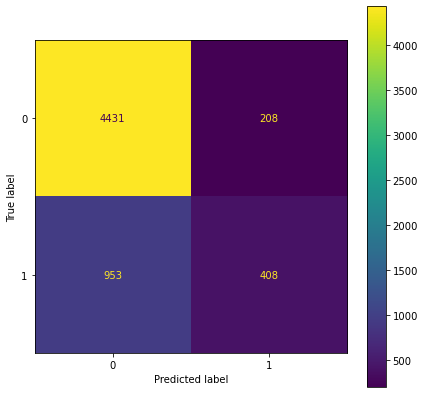

In [30]:
# Confusion matrix

fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(knn, X_val_preprocessed_scaled, y_val, ax=ax);

In [34]:
# Classification report
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=19)
knn.fit(X_train_norm, y_train_norm)

y_preds = knn.predict(x_val_preprocessed_scaled)
print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           0       0.88      0.60      0.71      4639
           1       0.34      0.71      0.46      1361

    accuracy                           0.63      6000
   macro avg       0.61      0.65      0.59      6000
weighted avg       0.75      0.63      0.66      6000



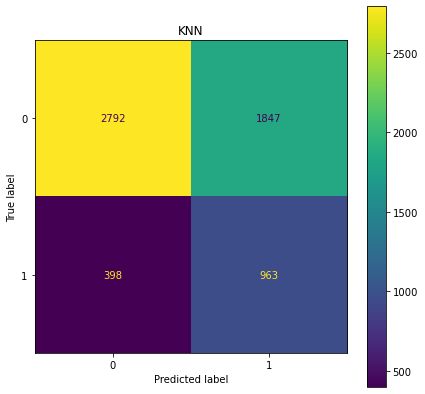

In [47]:
# Confusion matrix

fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(knn, x_val_preprocessed_scaled, y_val, ax=ax)
plt.title('KNN');

In [36]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X_train_preprocessed,y_train)

In [37]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_resampled, y_resampled)
y_preds = lr.predict(x_val_preprocessed)
print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           0       0.84      0.63      0.72      4639
           1       0.32      0.59      0.41      1361

    accuracy                           0.62      6000
   macro avg       0.58      0.61      0.57      6000
weighted avg       0.72      0.62      0.65      6000



/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


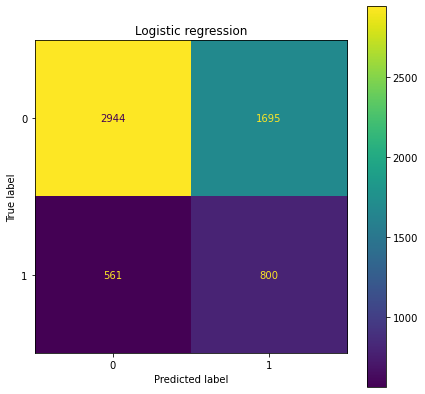

In [49]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(lr, x_val_preprocessed, y_val, ax=ax)
plt.title('Logistic regression');

In [40]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_resampled, y_resampled)
y_preds = rf.predict(x_val_preprocessed)
print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      4639
           1       0.60      0.46      0.52      1361

    accuracy                           0.81      6000
   macro avg       0.72      0.68      0.70      6000
weighted avg       0.79      0.81      0.80      6000



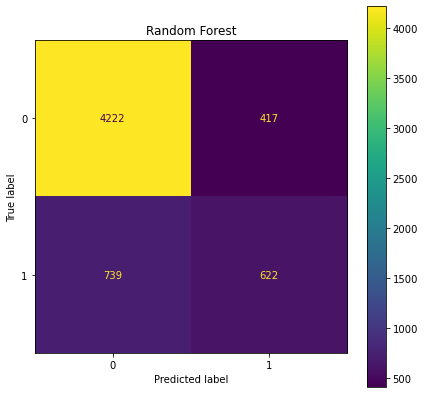

In [48]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(rf, x_val_preprocessed, y_val, ax=ax)
plt.title('Random Forest');